In this project we will be applying Linear Regression to predict the solubility of molecules (i.e. solubility of drugs is an important physicochemical property in Drug discovery, design and development).

# 1. Let's install some of the packages:

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-08-05 00:45:42--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   174MB/s    in 0.5s    

2021-08-05 00:45:42 (174 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

# 2. Now let's download the dataset for drug discovery

In [32]:
! wget https://raw.githubusercontent.com/dmy-collab/shared-projects/main/Linear%20regression%20drug%20solubility/compounds_list.csv

--2021-08-05 01:43:10--  https://raw.githubusercontent.com/dmy-collab/shared-projects/main/Linear%20regression%20drug%20solubility/compounds_list.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81353 (79K) [text/plain]
Saving to: ‘compounds_list.csv’

compounds_list.csv  100%[===================>]  79.45K  --.-KB/s    in 0.009s  

2021-08-05 01:43:10 (8.65 MB/s) - ‘compounds_list.csv’ saved [81353/81353]



# 2.1 Reading the file

In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('max_seq_item', None)
pd.set_option('display.width', 1000)

In [33]:
sol = pd.read_csv('compounds_list.csv')

> Initial reviev


In [34]:
print(sol.head())
print(sol.shape)
nulls = sol.isnull().sum().to_frame()   # searching for missing values
for index, row in nulls.iterrows():
    print(index, row[0])

  Compound ID  ESOL predicted log solubility in mols per litre  Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  Number of Rotatable Bonds  Polar Surface Area  measured log solubility in mols per litre                                                  SMILES
0   Amigdalin                                           -0.974               1           457.432                        7                3                          7              202.32                                      -0.77  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
1    Fenfuram                                           -2.885               1           201.225                        1                2                          2               42.24                                      -3.30                                  Cc1occc1C(=O)Nc2ccccc2
2      citral                                           -2.579               1           152.237                        0                0       

# 3. Calculate molecular descriptors in rdkit


# 3.1 Importing RDKIT for further convertion of molecule from the SMILES string to an rdkit object

In [35]:
from rdkit import Chem

In [37]:
mol_list = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [25]:
print(len(mol_list))

1128


# 3.2. Calculate molecular descriptors

To predict LogS (log of the aqueous solubility) we will need to use use of 4 molecular descriptors:

1.   cLogP (Octanol-water partition coefficient)
2.   MW (Molecular weight)
3.   RB (Number of rotatable bonds)
4.   AP (Aromatic proportion = number of aromatic atoms / total number of heavy atoms)

Rdkit readily computes only the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the number of aromatic atoms to the total number of heavy atoms which rdkit can compute.



# 3.2.1. LogP, MW and RB

In [38]:
import numpy as np
from rdkit.Chem import Descriptors

In [39]:
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [40]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,-3.10802,457.432,7.0
1,2.84032,201.225,2.0
2,2.87800,152.237,4.0
3,6.29940,278.354,0.0
4,1.74810,84.143,0.0
...,...,...,...
1123,2.50850,197.381,0.0
1124,0.10710,219.266,1.0
1125,2.99000,246.359,7.0
1126,2.05240,72.151,1.0


# 3.2.2. Aromatic proportion
> # 3.2.1.1. Number of aromatic atoms


Here, we will create a custom function to calculate the Number of aromatic atoms. With this descriptor we can use it to subsequently calculate the AP descriptor.

In [42]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [43]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[6,
 11,
 0,
 22,
 5,
 9,
 12,
 6,
 0,
 12,
 0,
 10,
 0,
 6,
 0,
 0,
 0,
 6,
 6,
 0,
 12,
 6,
 0,
 6,
 6,
 0,
 9,
 0,
 12,
 0,
 6,
 0,
 12,
 0,
 12,
 0,
 12,
 6,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 6,
 12,
 6,
 10,
 0,
 0,
 18,
 6,
 12,
 6,
 0,
 10,
 18,
 0,
 12,
 0,
 0,
 6,
 11,
 12,
 6,
 6,
 0,
 12,
 5,
 12,
 0,
 6,
 0,
 0,
 12,
 12,
 0,
 11,
 0,
 10,
 0,
 6,
 6,
 0,
 18,
 0,
 0,
 12,
 6,
 0,
 16,
 0,
 10,
 12,
 6,
 12,
 6,
 6,
 0,
 10,
 0,
 0,
 10,
 0,
 6,
 6,
 0,
 9,
 6,
 12,
 0,
 6,
 14,
 9,
 10,
 6,
 6,
 12,
 0,
 0,
 6,
 6,
 0,
 0,
 6,
 12,
 6,
 0,
 6,
 0,
 6,
 0,
 0,
 6,
 6,
 0,
 6,
 10,
 0,
 6,
 0,
 10,
 6,
 10,
 0,
 0,
 0,
 6,
 9,
 6,
 0,
 0,
 0,
 0,
 6,
 0,
 6,
 6,
 6,
 18,
 0,
 6,
 12,
 0,
 12,
 12,
 0,
 6,
 6,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 6,
 0,
 18,
 16,
 0,
 6,
 0,
 6,
 6,
 0,
 6,
 0,
 6,
 6,
 0,
 10,
 11,
 0,
 0,
 6,
 0,
 12,
 0,
 0,
 6,
 0,
 0,
 9,
 10,
 6,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 6,
 0,
 6,
 12,
 20,
 6,
 10,
 6,
 10,
 12,
 5,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 12,


# 3.2.1.2. Number of heavy atoms
Here, we will use an existing function for calculating the Number of heavy atoms.

In [44]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[32,
 15,
 11,
 22,
 5,
 9,
 17,
 20,
 19,
 29,
 6,
 11,
 5,
 16,
 14,
 4,
 6,
 8,
 19,
 12,
 17,
 17,
 13,
 13,
 22,
 8,
 13,
 15,
 18,
 11,
 10,
 15,
 22,
 4,
 14,
 6,
 13,
 17,
 21,
 8,
 13,
 6,
 12,
 11,
 6,
 8,
 11,
 15,
 25,
 12,
 8,
 17,
 18,
 14,
 18,
 8,
 9,
 12,
 19,
 6,
 20,
 8,
 28,
 8,
 19,
 26,
 15,
 9,
 12,
 14,
 17,
 18,
 11,
 18,
 9,
 9,
 28,
 15,
 4,
 22,
 14,
 11,
 4,
 8,
 10,
 8,
 33,
 6,
 11,
 19,
 11,
 17,
 16,
 7,
 12,
 20,
 14,
 16,
 9,
 9,
 24,
 14,
 10,
 3,
 12,
 4,
 10,
 9,
 4,
 19,
 11,
 21,
 5,
 7,
 15,
 13,
 10,
 21,
 12,
 13,
 6,
 8,
 11,
 10,
 10,
 15,
 15,
 29,
 6,
 8,
 8,
 27,
 15,
 11,
 10,
 9,
 11,
 11,
 8,
 11,
 5,
 8,
 5,
 11,
 8,
 11,
 2,
 16,
 5,
 9,
 19,
 8,
 7,
 6,
 4,
 7,
 11,
 5,
 16,
 8,
 14,
 26,
 7,
 14,
 19,
 11,
 14,
 30,
 5,
 23,
 10,
 15,
 23,
 2,
 20,
 29,
 10,
 15,
 10,
 16,
 6,
 28,
 19,
 4,
 17,
 23,
 6,
 10,
 30,
 8,
 13,
 20,
 15,
 5,
 11,
 22,
 6,
 9,
 8,
 7,
 17,
 3,
 3,
 19,
 17,
 4,
 10,
 11,
 7,
 4,
 6,
 7,
 11,
 11,
 22,
 1

# 3.2.1.3. Computing the Aromatic Proportion (AP) descriptor

In [45]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.1875,
 0.7333333333333333,
 0.0,
 1.0,
 1.0,
 1.0,
 0.7058823529411765,
 0.3,
 0.0,
 0.41379310344827586,
 0.0,
 0.9090909090909091,
 0.0,
 0.375,
 0.0,
 0.0,
 0.0,
 0.75,
 0.3157894736842105,
 0.0,
 0.7058823529411765,
 0.35294117647058826,
 0.0,
 0.46153846153846156,
 0.2727272727272727,
 0.0,
 0.6923076923076923,
 0.0,
 0.6666666666666666,
 0.0,
 0.6,
 0.0,
 0.5454545454545454,
 0.0,
 0.8571428571428571,
 0.0,
 0.9230769230769231,
 0.35294117647058826,
 0.0,
 0.0,
 0.9230769230769231,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5454545454545454,
 0.8,
 0.24,
 0.8333333333333334,
 0.0,
 0.0,
 1.0,
 0.42857142857142855,
 0.6666666666666666,
 0.75,
 0.0,
 0.8333333333333334,
 0.9473684210526315,
 0.0,
 0.6,
 0.0,
 0.0,
 0.75,
 0.5789473684210527,
 0.46153846153846156,
 0.4,
 0.6666666666666666,
 0.0,
 0.8571428571428571,
 0.29411764705882354,
 0.6666666666666666,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.42857142857142855,
 0.8,
 0.0,
 0.5,
 0.0,
 0.9090909090909091,
 0.0,
 0.75,
 0.6,
 0.0,
 

*Converting to dataframe:*

In [46]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.187500
1,0.733333
2,0.000000
3,1.000000
4,1.000000
...,...
1123,0.000000
1124,0.000000
1125,0.000000
1126,0.000000


# 3.3. Combining all computed descriptors into 1 dataframe

# X matrix (features for further modeling)

In [48]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,-3.10802,457.432,7.0,0.187500
1,2.84032,201.225,2.0,0.733333
2,2.87800,152.237,4.0,0.000000
3,6.29940,278.354,0.0,1.000000
4,1.74810,84.143,0.0,1.000000
...,...,...,...,...
1123,2.50850,197.381,0.0,0.000000
1124,0.10710,219.266,1.0,0.000000
1125,2.99000,246.359,7.0,0.000000
1126,2.05240,72.151,1.0,0.000000


# 3.4. Y matrix

In [49]:
sol.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,SMILES
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


*Assigning the second column (index 1) to the Y matrix (labels for further modeling)*

In [50]:
Y = sol.iloc[:,1]
Y

0      -0.974
1      -2.885
2      -2.579
3      -6.618
4      -2.232
        ...  
1123   -2.608
1124   -0.908
1125   -3.323
1126   -2.245
1127   -4.320
Name: ESOL predicted log solubility in mols per litre, Length: 1128, dtype: float64

Splitting the dataset into the Training set and Test set:

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=101)

# Training the Linear Regression model and evaluation:

In [54]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

In [57]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# *Predict X_train*

In [58]:
Y_pred_train = model.predict(X_train)

In [59]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.64862091 -0.00508978 -0.01465451 -0.84788128]
Intercept: -0.024009428120612686
Mean squared error (MSE): 0.17
Coefficient of determination (R^2): 0.94


# *Predict X_test*

In [60]:
Y_pred_test = model.predict(X_test)

In [62]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.64862091 -0.00508978 -0.01465451 -0.84788128]
Intercept: -0.024009428120612686
Mean squared error (MSE): 0.12
Coefficient of determination (R^2): 0.96


# Now let's use entire dataset for model training (For Comparison)

In [63]:

full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
full_pred = model.predict(X)

In [ ]:
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

# Scatter plot of experimental vs. predicted LogS

In [68]:
import matplotlib.pyplot as plt

# *Quick check of the variable dimensions of Train and Test sets*

In [65]:
Y_train.shape, Y_pred_train.shape

((902,), (902,))

In [66]:

Y_test.shape, Y_pred_test.shape

((226,), (226,))

# Vertical plot

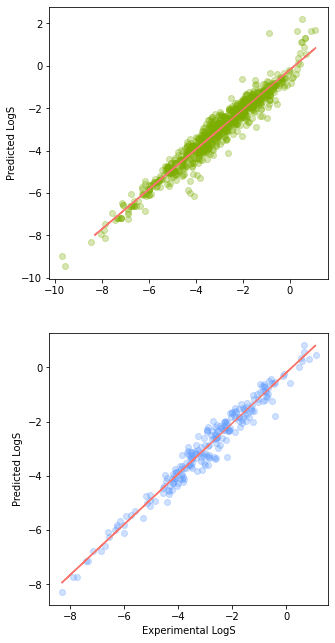

In [69]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

# Horizontal plot

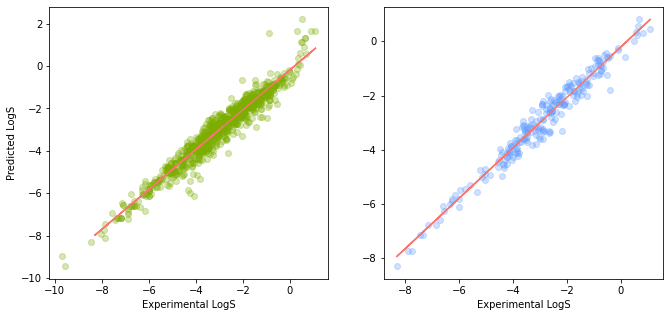

In [70]:
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()